# Imports

In [1]:
import numpy as np  
import pandas as pd  
import seaborn as sns  
import shap  
import matplotlib.pyplot as plt  
from scipy import stats  
from scipy.stats import uniform, randint  

# Sklearn utilities  
from sklearn import set_config  
from sklearn.base import BaseEstimator, TransformerMixin  
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor  
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion  
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV, GridSearchCV, 
    cross_validate, cross_val_score, cross_val_predict, StratifiedKFold
)  
from sklearn.preprocessing import (
    MinMaxScaler, StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
)  
from sklearn.impute import SimpleImputer  
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector  
from sklearn.inspection import permutation_importance  

# Sklearn models  
from sklearn.linear_model import ElasticNet, LogisticRegression  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier  

# Imbalanced Learning  
from imblearn.under_sampling import TomekLinks, RandomUnderSampler  
from imblearn.pipeline import Pipeline as unb_Pipeline  

# Boosting Models  
from xgboost import XGBClassifier  
from lightgbm import LGBMClassifier  
from catboost import CatBoostClassifier  

# Evaluation Metrics  
from sklearn.metrics import (
    make_scorer, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
)  

# extra  
set_config(transform_output="pandas")  
from contextlib import suppress

# Helpers

In [2]:
def split_data(df, target=None):
    
    if target == None:
        target = list(df.columns)[-1]
    return df.drop(columns=[target], axis=1), df[[target]]

In [3]:
def explore_data(training_data, cols=None, size=None):
    
    if size == None:
        num_cols = len(training_data.columns)
        base_size = 5 # Base size for each plot
        fig_height = base_size * num_cols * 0.6
        fig_width = base_size * 2 
        print("hi")
        size = (fig_width, fig_height)
        
    # this way, you can specify, or if you dont, all numerical columns will be displayed
    if cols == None:
        cols = training_data.select_dtypes(include='number').columns
    
    fig, ax = plt.subplots(len(cols), 2, figsize=(size[0], size[1]))
    for i, col in enumerate(cols):
        try:
            ax[i][0].set_title(f"{col} - Histogram")
            ax[i][0].hist(training_data[[col]], bins=30)
            ax[i][1].set_title(f"{col} - Boxplot")
            ax[i][1].boxplot(training_data[[col]])
        except ValueError as e:
            pass
            
    fig.tight_layout()

In [4]:
def list_transfer(list1, list2, column):

    if column in list1:
        list1.remove(column)  # Remove the element from list1
        list2.append(column)  # Add the element to list2
    else:
        raise ValueError(f"'{column}' not found in list1.")

In [5]:
def get_feature_nans_values(data, cols=None):
    if cols == None:
        cols = data.columns
    # find ordinal features
    info_tuple = [] 
    
    for col in cols:
        # values
        num_values = len(data[col].value_counts())
        # nan ratio
        nan_ratio = data[col].isna().mean()
    
        # create tuple
        tup = (num_values, col, nan_ratio)
        info_tuple.append(tup)
        
    info_tuple.sort(reverse=True)
    
    for i in info_tuple:
        print(i[0], "\t", round(i[2],2), "\t", i[1])

In [6]:
def analyze_numerical_features(X_train, numerical_features, significance_level=1e-80):

    feature_info = []
    non_scaling_numerical_features = []
    gaussian_continuous_features = []
    non_gaussian_continuous_features = []

    for col in numerical_features:
        
        num_values = len(X_train[col].value_counts())
        nan_ratio = X_train[col].isna().mean()
        tup = (num_values, col, nan_ratio)
        feature_info.append(tup)

        if num_values <= 30:
            non_scaling_numerical_features.append(col)
        else:
            try:
                # Perform Shapiro-Wilk test for Gaussian distribution
                _, p_value = stats.shapiro(X_train[[col]].dropna())
                
                # Categorize based on p-value
                if p_value < significance_level:
                    non_gaussian_continuous_features.append(col)
                else:
                    gaussian_continuous_features.append(col)
            except ValueError as e:
                print(f"Error in column {col}: {e}")


    return feature_info, non_scaling_numerical_features, gaussian_continuous_features, non_gaussian_continuous_features

In [7]:
# Define a custom scorer for recall on class 0 (defaulters)
recall_default_scorer = make_scorer(
    recall_score,
    pos_label=0
)

# Initial data handling

## Loading, Duplicates, Splitting

In [8]:
# Load the data, immediately drop duplicates and then split to avoid data leakage
data = pd.read_excel("Two_DS_Tech_Test.xlsx", index_col="borrower_id")
data = data.drop_duplicates()

In [9]:
X, y = split_data(data, 'outcome')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [10]:
y_train.value_counts()


outcome   
Fully Paid    32007
Defaulted       793
Name: count, dtype: int64

# EDA

## datatypes

In [11]:
with pd.option_context("display.max_rows", None):
    print(X_train.dtypes)


loan_amnt                                float64
term                                      object
emp_title                                 object
emp_length                                object
home_ownership                            object
annual_inc                               float64
purpose                                   object
addr_state                                object
dti                                      float64
delinq_2yrs                                int64
earliest_cr_line                  datetime64[ns]
inq_last_6mths                             int64
mths_since_last_delinq                   float64
mths_since_last_record                   float64
open_acc                                   int64
pub_rec                                    int64
revol_bal                                  int64
revol_util                               float64
total_acc                                  int64
collections_12_mths_ex_med                 int64
mths_since_last_majo

In [12]:
numerical_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(exclude=np.number).columns

## Declare all column groups

To impute with a continious average, I will use either a mean or median depending on whether or not the data is gaussian or not later verified with the shapiro-wilks test.

In [13]:
# Typical features

numerical_features = X_train.select_dtypes(include=np.number).columns
categorical_features = X_train.select_dtypes(exclude=np.number).columns

# scaling
gaussian_continuous_features = []  # For mean
non_gaussian_continuous_features = []  # For MinMaxScaler
non_scaling_numerical_features = []  # For features with <= 30 unique values

# conversions
to_binary_features = [] 
to_ordinal_features = [] # features with an inherent order
to_ohe_features = [] # features for a one hot encoder
to_binary_features = [] # binary features
to_binning_features = [] # features to be binned
to_drop_features = [] # features to drop

## Checking for outliers

In [14]:
def detect_rows_with_outliers(df, threshold_percent=0.3, iqr_threshold=1.5):

    if not isinstance(df, pd.DataFrame):
        raise ValueError("Input must be a pandas DataFrame.")

    outlier_flags = pd.DataFrame(index=df.index, columns=df.columns, dtype=bool)

    for col in df.select_dtypes(include=[np.number]).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - iqr_threshold * IQR
        upper_bound = Q3 + iqr_threshold * IQR
        outlier_flags[col] = (df[col] < lower_bound) | (df[col] > upper_bound)

    outlier_percentage = outlier_flags.mean(axis=1)
    rows_with_outliers = outlier_percentage > threshold_percent

    return rows_with_outliers

In [15]:
# No rows have more than 30% outliers
np.all(detect_rows_with_outliers(X_train) == False)

False

## Feature separation

The feature separation at this level is manual.

- `nan_impute_with_average_features` is for features that I will impute with either a mean or median.
- `nan_impute_categorical_features` I will impute categorical features with either the most frequent
- `nan_impute_recent_time_features` is for things that have happened recently. I will assume a nan means no recent occurrences. (Impute with 0)
- `nan_impute_quantity_features` is for quantities, I will assume a NaN means no occurrences. (Impute with 0)

`nan_impute_temporal_safety_indicator_features` and `nan_impute_temporal_risk_indicator_features` are more complicated. For the safety indicators (time since good), a low score means something that indicates safety only just happened, which is bad. You want a high value here to ensure that the thing happened in the past and has a history. Take `mo_sin_old_il_acct`. If it is greater that suggests more history which is good

For the risk indicators (time since bad) the logic is flipped. A high value indicates the time since a bad thing happened is high, which is good. Take `mths_since_recent_revol_delinq` as an example. If there is a nan here it means that there is no record of a recent delinquency on a revolving account. This is ideal, and so we impute with the the 90th percentile of this feature.

For time since good im imputing nans with 0, with time since bad imputing with the 90th percentile of the feature. I pick the 90th percentile to stop outliers from dominating the model.

There is also a list of certain features that were special even beyond my consideration. These features could have NaNs that can be interpreted in multiple ways and therefore, handling them was more difficult. I chose a more basic approach with them, but wanted to note their existence. More careful handling of NaNs in these features is something I would do if I had more time.

In [16]:
# nan handling groups

nan_impute_with_average_features = [
    'loan_amnt', 'dti', 'revol_bal', 'tot_coll_amt','mths_since_recent_bc',
    'tot_cur_bal', 'total_bal_il', 'max_bal_bc', 'avg_cur_bal', 'tax_liens',
    'bc_open_to_buy', 'tot_hi_cred_lim', 'total_bal_ex_mort', 
    'total_bc_limit', 'total_il_high_credit_limit', 'total_rev_hi_lim',
    'open_acc', 'pub_rec', 'total_acc','revol_util', 'il_util', 'all_util', 
    'bc_util', 'pct_tl_nvr_dlq','percent_bc_gt_75', 'pub_rec_bankruptcies',
]

nan_impute_categorical_features = [ 
    # types of things eg job title, purpose
    'term', 'emp_title', 'emp_length', 'home_ownership', 'purpose',
    'addr_state',
]

nan_impute_temporal_safety_indicator_features = [ 
    # time since occurrence of safety indicator
    'earliest_cr_line', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
]

nan_impute_temporal_risk_indicator_features = [ 
    # time since occurrence of risk indicator
    'mths_since_last_delinq', 'mths_since_last_record',
    'mths_since_last_major_derog', 'mths_since_recent_bc_dlq',
    'mths_since_recent_revol_delinq',
    
    "mths_since_recent_inq", 'mo_sin_rcnt_tl','mths_since_rcnt_il', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl'
]

nan_impute_recent_time_features = [ 
    # impute 0 
    'collections_12_mths_ex_med', 'acc_now_delinq', 'chargeoff_within_12_mths',
    'delinq_amnt', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
    'open_il_12m', 'open_il_24m', 'open_acc_6m','open_rv_12m','open_rv_24m',
    'delinq_2yrs',  'inq_last_6mths','open_act_il', 'num_tl_op_past_12m',

    'inq_last_12m', 'acc_open_past_24mths',
]

nan_impute_quantity_features = [ # impute 0
    'num_bc_sats', 'num_rev_tl_bal_gt_0', 'num_actv_bc_tl','annual_inc','num_sats', 
    'num_accts_ever_120_pd', 'num_actv_rev_tl', 'num_bc_tl','num_il_tl', 'num_op_rev_tl', 
    'num_rev_accts', 
    
    'inq_fi', 'total_cu_tl', 'mort_acc', 
]




There are also some special features where nans can be interpreted in multiple ways. I didnt have time to handle them specially, but wanted to acknowledge some of them.

In [17]:
# Special consideration features
# revol_util
# il_util
# all_util
# bc_util
# pct_tl_nvr_dlq
# percent_bc_gt_75
# mo_sin_rcnt_tl
# mths_since_rcnt_il
# num_bc_sats 
# num_sats
# num_rev_tl_bal_gt_0
# num_actv_bc_tl

In [18]:
all_nan_cols = set(nan_impute_with_average_features) | \
               set(nan_impute_categorical_features) | \
               set(nan_impute_temporal_safety_indicator_features) | \
               set(nan_impute_temporal_risk_indicator_features) | \
               set(nan_impute_recent_time_features) | \
               set(nan_impute_quantity_features)

x_train_cols = set(X_train.columns)
non_nan_cols = x_train_cols - all_nan_cols
non_nan_cols_list = list(non_nan_cols)

print(f"Total columns in X_train: {len(x_train_cols)}")
print(f"Total NaN columns: {len(all_nan_cols)}")
print(f"Number of columns not in NaN sets: {len(non_nan_cols)}")
print("\nColumns not in NaN sets:")
print(non_nan_cols_list)

Total columns in X_train: 76
Total NaN columns: 76
Number of columns not in NaN sets: 0

Columns not in NaN sets:
[]


## Detailed investigation into features and feature sets

In [19]:
get_feature_nans_values(X_train)

29132 	 0.06 	 tot_cur_bal
27201 	 0.06 	 tot_hi_cred_lim
27120 	 0.04 	 total_bal_ex_mort
22047 	 0.0 	 revol_bal
21786 	 0.06 	 total_il_high_credit_limit
19438 	 0.06 	 avg_cur_bal
16779 	 0.11 	 emp_title
15366 	 0.05 	 bc_open_to_buy
9050 	 0.67 	 total_bal_il
7041 	 0.67 	 max_bal_bc
4582 	 0.0 	 annual_inc
3909 	 0.0 	 dti
3173 	 0.06 	 total_rev_hi_lim
2317 	 0.04 	 total_bc_limit
1804 	 0.06 	 tot_coll_amt
1269 	 0.0 	 loan_amnt
1116 	 0.05 	 bc_util
1076 	 0.0 	 revol_util
611 	 0.0 	 earliest_cr_line
599 	 0.06 	 mo_sin_old_rev_tl_op
378 	 0.06 	 pct_tl_nvr_dlq
375 	 0.09 	 mo_sin_old_il_acct
270 	 0.05 	 mths_since_recent_bc
186 	 0.68 	 mths_since_rcnt_il
160 	 0.06 	 mo_sin_rcnt_rev_tl_op
157 	 0.71 	 il_util
153 	 0.0 	 delinq_amnt
132 	 0.67 	 all_util
120 	 0.83 	 mths_since_last_record
116 	 0.05 	 percent_bc_gt_75
112 	 0.74 	 mths_since_last_major_derog
111 	 0.06 	 mo_sin_rcnt_tl
108 	 0.68 	 mths_since_recent_revol_delinq
107 	 0.77 	 mths_since_recent_bc_dlq
101 

hi


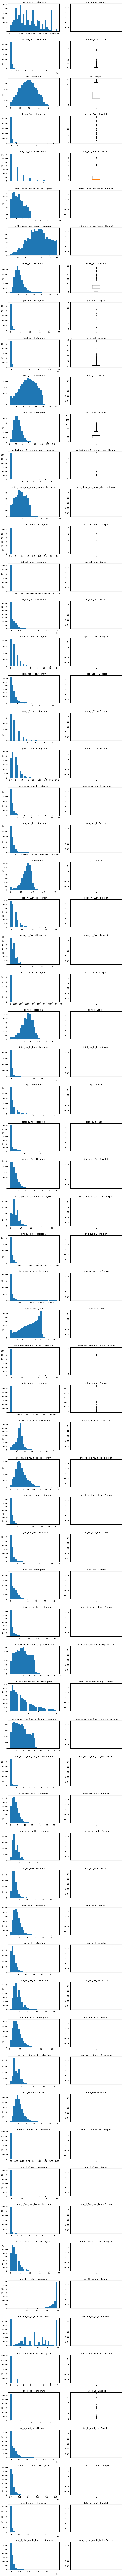

In [20]:
explore_data(X_train[numerical_features], list(numerical_features))

I make a few key decisions at this point regarding the categorical features.
- `emp_title` - I decided to drop this feature. I considered feature hashing due to the high level of variability, but realised that for the same reason, it wouldn't add much information to the model. It would be ideal to use some sort of NLP solution to get usage out of this feature.
- `home_ownership` - I ordinally encoded this as certain types of homeowners are more likely to repay loans. I.e. someone who owns a home is more likely to pay off a loan than someone who rents it. 
- `purpose` - I one hot encoded this feature because it is categorical, low feature count, and has no order.
- `addr_state` - I decided to drop this feature. It would be possible once again to use feature hashing to reduce dimensionality. However, a ML model used to inform decisions around loans would be considered unethical and forbidden. It is not ideal behaviour.
- `earliest_cr_line` - I changed this feature to be the time (in years) since the earliest credit line was opened, but kept the original column name. A more distant credit line being opened is good, so a higher value would be better. So when a nan exists in this column, I assume no credit line has been opened, and I impute with the max.
- `term` - I ordinal encoded this feature as term length has an inherent order. One of the weaknesses of my approach is visible here. Judging by `X_train`, I assume that term length will always be one of the 2 options visible. I avoid data leakage, but this is not a scaleable design choice, and is something that needs to be fixed with a dynamic transformer.
- `emp_length` - I ordinally encoded this feature as an order is inherent to it.




In [21]:
to_drop_features.append("addr_state")  # discriminating based on state could lead to lawsuits
to_drop_features.append("emp_title")  # too much variation, would likely require NLP solution

In [22]:
to_binary_features.append("term") # will be ordinally encoded later on

This is where I separate features into gaussian/non gaussian groups. Initially I planned to scale my data, which is why a have a list of non_scaling_numerical_features that are in neither group. 

Ultimately for reasons we will discuss later, I will not be scaling my features. Still, I use these lists to determine what Imputing strategy I should use for my features (Mean for gaussian, Median for Non gaussian to better approximate the mean).

In [23]:
feature_info, non_scaling, gaussian, non_gaussian = analyze_numerical_features(
X_train, numerical_features, significance_level=1e-80)

# Update the feature categorization lists
non_scaling_numerical_features.extend(non_scaling)
gaussian_continuous_features.extend(gaussian)
non_gaussian_continuous_features.extend(non_gaussian)

feature_info.sort(reverse=True)

/home/javonne/anaconda3/envs/fraud/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32780.
  res = hypotest_fun_out(*samples, **kwds)
/home/javonne/anaconda3/envs/fraud/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32800.
  res = hypotest_fun_out(*samples, **kwds)
/home/javonne/anaconda3/envs/fraud/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 32800.
  res = hypotest_fun_out(*samples, **kwds)
/home/javonne/anaconda3/envs/fraud/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15874.
  res = hypotest_fun_out(*samples, **kwds)


In [24]:
# use mean/median depending on if the feature distribution is gaussian or not
nan_impute_with_mean = []
nan_impute_with_median = []

for feature in nan_impute_with_average_features:
    if feature in gaussian_continuous_features:
        nan_impute_with_mean.append(feature)
    elif feature in non_gaussian_continuous_features:
        nan_impute_with_median.append(feature)
    elif feature in non_scaling_numerical_features:
        nan_impute_with_median.append(feature)
    else:
        print(feature)


In [25]:
# remove already identified categorical features/ drop features

# impute mean
gaussian_continuous_features = list(set(gaussian_continuous_features) - set(categorical_features) - set(to_drop_features))

# impute median
non_gaussian_continuous_features = list(set(non_gaussian_continuous_features) - set(categorical_features) - set(to_drop_features))
non_scaling_numerical_features = list(set(non_scaling_numerical_features) - set(categorical_features) - set(to_drop_features))

In [26]:
# sanity check 
assert len(numerical_features) == len(set(gaussian_continuous_features + non_gaussian_continuous_features + non_scaling_numerical_features) - set(to_drop_features))

In [27]:
# Removal of unwanted features from nan impute lists
nan_impute_categorical_features = list(set(nan_impute_categorical_features)-set(to_drop_features))
nan_impute_quantity_features = list(set(nan_impute_quantity_features)-set(to_drop_features))
nan_impute_recent_time_features = list(set(nan_impute_recent_time_features)-set(to_drop_features))
nan_impute_temporal_risk_indicator_features = list(set(nan_impute_temporal_risk_indicator_features)-set(to_drop_features))
nan_impute_temporal_safety_indicator_features = list(set(nan_impute_temporal_safety_indicator_features)-set(to_drop_features))
nan_impute_with_average_features = list(set(nan_impute_with_average_features)-set(to_drop_features))
nan_impute_with_mean = list(set(nan_impute_with_mean)-set(to_drop_features))
nan_impute_with_median = list(set(nan_impute_with_median)-set(to_drop_features))


## Visualising features 

hi


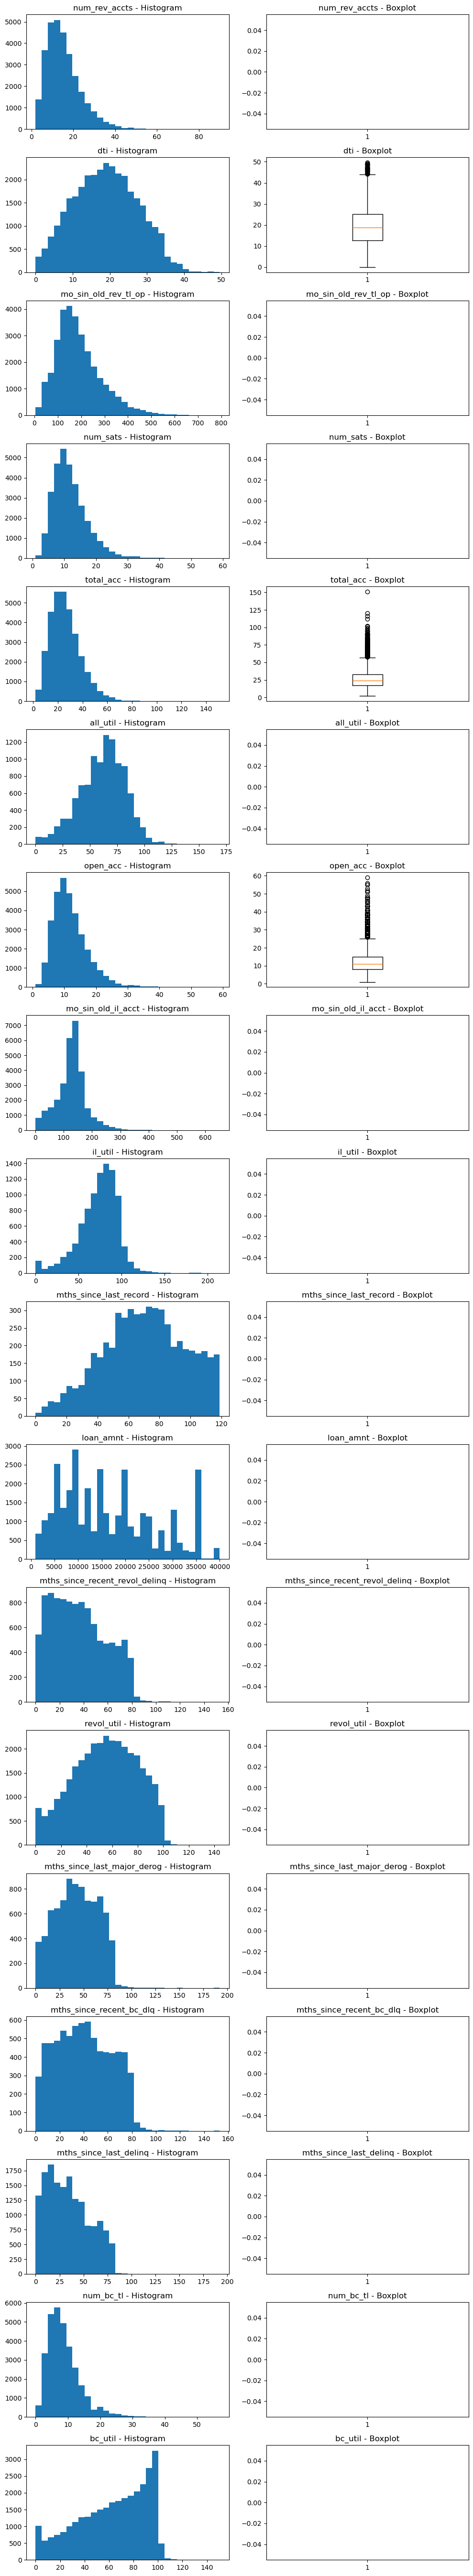

In [28]:
explore_data(X_train[gaussian_continuous_features], list(gaussian_continuous_features))

hi


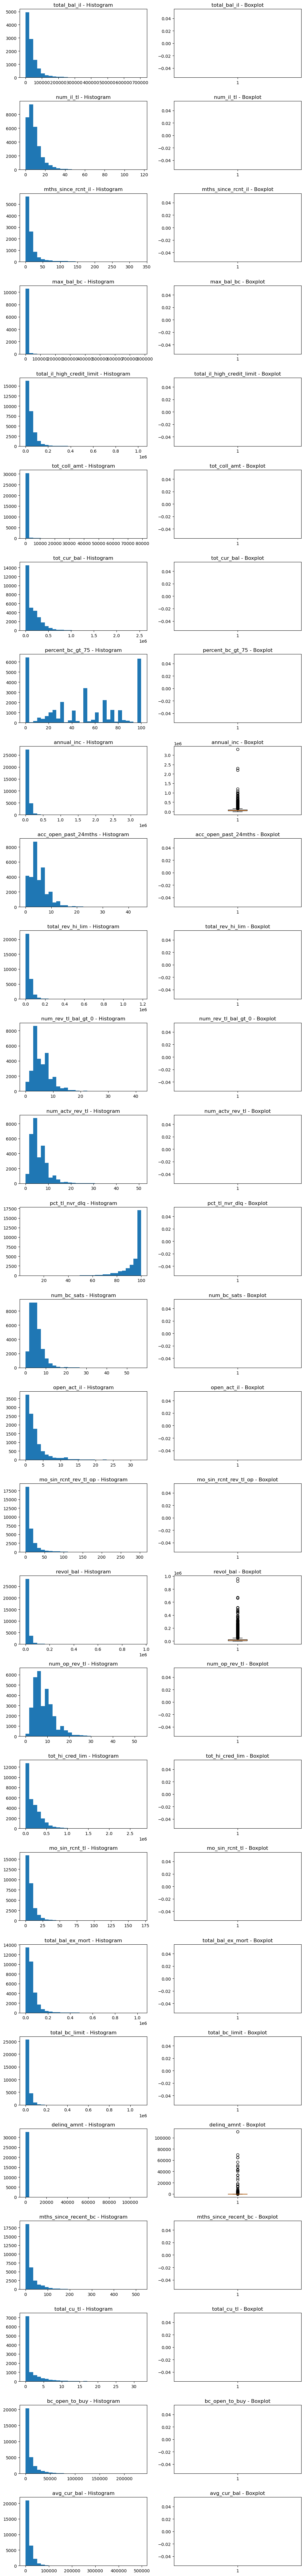

In [29]:
explore_data(X_train[non_gaussian_continuous_features], list(non_gaussian_continuous_features))

hi


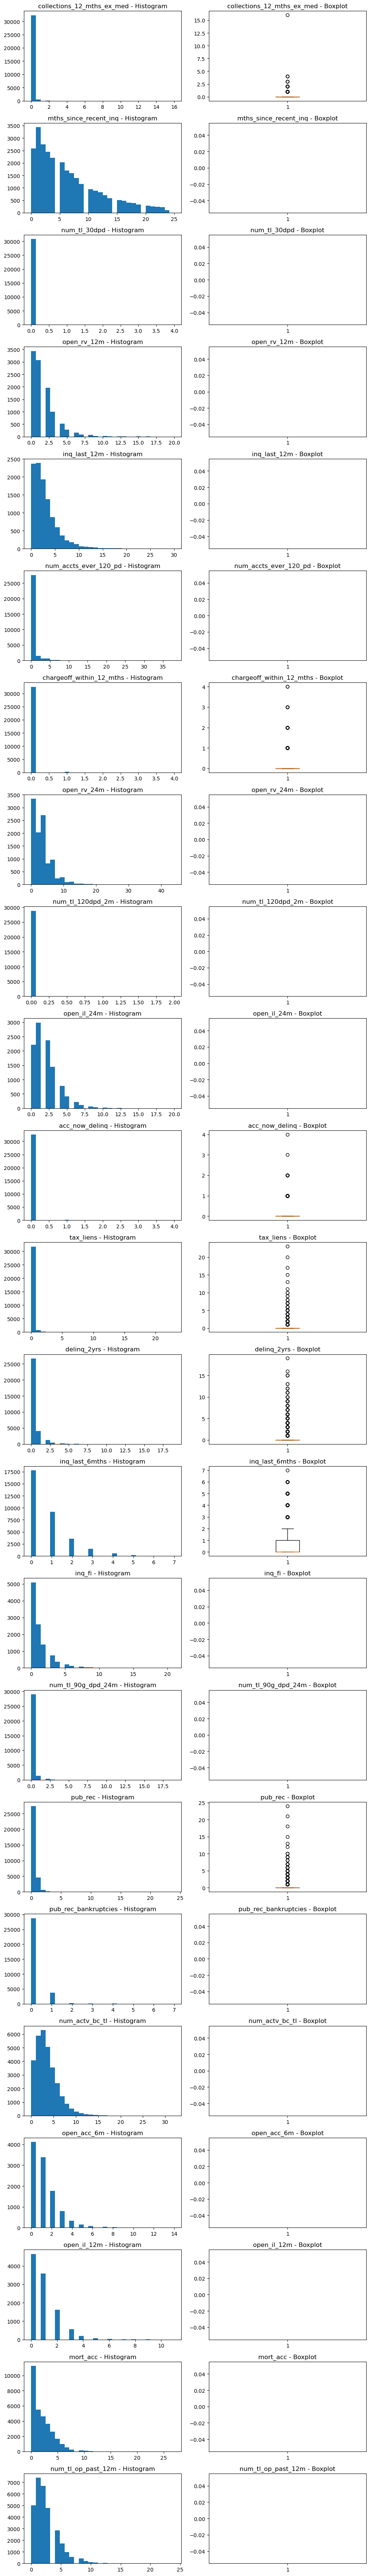

In [30]:
explore_data(X_train[non_scaling_numerical_features], list(non_scaling_numerical_features))

## Reorganising features into different groups

Because I used automation to assign featuers, some have to be move around manually.

I also decide to bin `percent_bc_gt_75`. It appears normally distributed, but has clusters at 0% and 100%. This definitely requires a binning solution.

(array([6.442e+03, 2.300e+01, 1.530e+02, 4.880e+02, 3.650e+02, 6.410e+02,
        1.015e+03, 1.240e+03, 3.820e+02, 2.025e+03, 4.200e+01, 2.160e+02,
        1.175e+03, 1.530e+02, 3.000e+00, 3.412e+03, 1.320e+02, 2.700e+02,
        9.980e+02, 2.900e+01, 2.209e+03, 3.020e+02, 1.259e+03, 8.900e+01,
        1.207e+03, 2.400e+02, 1.890e+02, 8.500e+01, 2.000e+00, 6.320e+03]),
 array([  0.        ,   3.33333333,   6.66666667,  10.        ,
         13.33333333,  16.66666667,  20.        ,  23.33333333,
         26.66666667,  30.        ,  33.33333333,  36.66666667,
         40.        ,  43.33333333,  46.66666667,  50.        ,
         53.33333333,  56.66666667,  60.        ,  63.33333333,
         66.66666667,  70.        ,  73.33333333,  76.66666667,
         80.        ,  83.33333333,  86.66666667,  90.        ,
         93.33333333,  96.66666667, 100.        ]),
 <BarContainer object of 30 artists>)

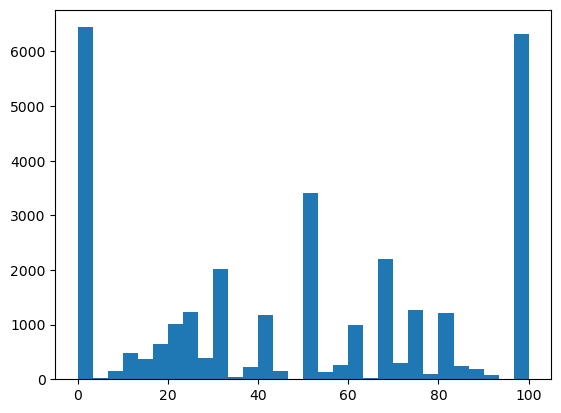

In [31]:
plt.hist(X_train["percent_bc_gt_75"], bins=30)

In [32]:
list_transfer(gaussian_continuous_features, non_gaussian_continuous_features, "mths_since_last_delinq")
list_transfer(gaussian_continuous_features, non_gaussian_continuous_features, "bc_util")
list_transfer(gaussian_continuous_features, non_gaussian_continuous_features, "loan_amnt")

list_transfer(non_gaussian_continuous_features,non_scaling_numerical_features,"percent_bc_gt_75")
to_binning_features.append("percent_bc_gt_75")

ohe_features = list(set(categorical_features) - set(to_drop_features) - {"earliest_cr_line", "term"})

to_ordinal_features.append("emp_length")
to_ordinal_features.append("home_ownership")

In [33]:
# checking we scale all relevant features
assert len(numerical_features) == len(gaussian_continuous_features) + len(non_gaussian_continuous_features) + len(non_scaling_numerical_features)

In [34]:
# drop the undesired features from dataset
X_train.drop(labels=to_drop_features, axis=1, inplace=True)

# Pipelines

## Feature engineering pipeline

I implement Feature Engineering in a custom sklean transformer. I come up with 8 total features.

- `income_to_loan_ratio` - A poor/high ratio would be a massive red flag here. It suggests you are requesting too much. 
- `revol_bal_to_income` - I suspected ratios would be very useful features to engineer. If your income is too high a percentage of your income, that is a red flag for loan repatment.
- `recent_credit_activity` - Recent credit activity is indicative loan repayment likelihood, so I wanted to capture that with some of my features.
- `recent_delinq` - Recent delinquency is a risk indicator for loan repayment.
- `delinq_per_acc` - Many delinquencies per account is a risk indicator for debt repayment.
- `installment_ratio` - An imbalance here (too many installment accounts) suggests someone may not repay a loan.
- `recent_revol_trend` -` - Recent credit activity is indicative loan repayment likelihood, so I wanted to capture that with some of my features.
- `dti_plus_revol_util` - I just added 2 features that I thought may be relevant in an attempt to get a composite more relevant feature instead of them.

In [35]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, handle_divisions=True):
        self.handle_divisions = handle_divisions
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        X = X.copy()
        
        X['income_to_loan_ratio'] = X['annual_inc'] / (X['loan_amnt'] + 1e-100)
        X['recent_delinq'] = (X['mths_since_last_delinq'] < 12).astype(int)
        X['revol_bal_to_income'] = X['revol_bal'] / (X['annual_inc'] + 1e-100)
        X['recent_credit_activity'] = X['open_acc_6m'] / (X['total_acc'] + 1e-100)
        X['delinq_per_acc'] = X['delinq_2yrs'] / (X['total_acc'] + 1e-100)
        X['installment_ratio'] = X['num_il_tl'] / (X['num_rev_accts'] + 1e-100)
        X['dti_plus_revol_util'] = X['dti'] + X['revol_util']
        X['recent_revol_trend'] = X['open_rv_12m'] - X['open_rv_24m']

        engineered_features = [
            'income_to_loan_ratio', 'revol_bal_to_income', 
            'dti_plus_revol_util', 'recent_credit_activity', 
            'recent_delinq', 'delinq_per_acc', 
            'installment_ratio', 'recent_revol_trend'
        ]
        
        if self.handle_divisions:
            for col in engineered_features:
                X[col] = X[col].mask(X[col] > 100, -1).replace([np.inf, -np.inf], -1)
                
        return X 

## Custom encoders

In [36]:
class OutlierColumnRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.3):  # Fraction of data considered outliers
        self.threshold = threshold
        self.too_many_outliers = []

    def fit(self, X, y=None):
        # Type check
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")
        
        self.too_many_outliers = []
        
        for col in X.select_dtypes(include=[np.number]):
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outlier_ratio = ((X[col] < lower_bound) | (X[col] > upper_bound)).mean()
            
            if outlier_ratio > self.threshold:
                self.too_many_outliers.append(col)
        
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")
        
        transformed_X = X.drop(columns=self.too_many_outliers, errors='ignore')
        return transformed_X

In [37]:
class NanColumnRemover(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=80):
        self.threshold = threshold
        self.too_many_nans = []

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        for col in X:
            nan_ratio = X[col].isna().sum() / len(X)
            if nan_ratio > self.threshold:
                self.too_many_nans.append(col)

        return self
        
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input must be a pandas DataFrame")

        transformed_X = X.drop(columns=self.too_many_nans)
        return transformed_X

In [38]:
class PersonalisedOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, order_info):
        self.order_info = order_info
        self.encoders = {}
        
    def fit(self, X, y=None):
        
        X = pd.DataFrame(X)
        
        for col in self.order_info.keys():
            self.encoders[col] = OrdinalEncoder(categories=[self.order_info[col]])
        
        return self
    
    def transform(self, X):
        
        X_encoded = pd.DataFrame(X.copy())
        for col, encoder in self.encoders.items():
            
            # check we have all of the possible feature values 
            unique_vals = pd.unique(X_encoded[col])
            unexpected_vals = [val for val in unique_vals if val not in self.order_info[col]]
            if unexpected_vals:
                raise Exception(f"That feature value is new...\nLook:{unexpected_vals}")
            
            X_encoded[col] = encoder.fit_transform(X_encoded[[col]])
        
        return pd.DataFrame(X_encoded)

In [39]:
class CustomBinningOperator(BaseEstimator, TransformerMixin):
    
    def __init__(self, binning_info):
        self.binning_info = binning_info
        self.binners = {}
        
    def fit(self, X, y=None):
        X = pd.DataFrame(X)
        for col in self.binning_info.keys():
            if col not in X.columns:
                raise ValueError(f"Column {col} not found in input data")
            
            bins = self.binning_info[col]
            if not all(bins[i] <= bins[i+1] for i in range(len(bins)-1)):
                raise ValueError(f"Bin edges must be in ascending order for {col}")
                
        return self
    
    def transform(self, X):
        X_binned = pd.DataFrame(X.copy())
        
        for col, bins in self.binning_info.items():
            # Check if values fall outside bin ranges
            if X_binned[col].min() < bins[0] or X_binned[col].max() > bins[-1]:
                raise ValueError(f"Values in {col} fall outside bin ranges")
            
            X_binned[col] = pd.cut(X_binned[col], 
                                 bins=bins, 
                                 labels=range(len(bins)-1),
                                 include_lowest=True)
            
            X_binned[col] = X_binned[col].astype(int)
            
        return X_binned
    
    def get_bin_labels(self, feature):
        bins = self.binning_info[feature]
        return [f"{bins[i]} to {bins[i+1]}" for i in range(len(bins)-1)]

In [40]:
class DateTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, date_feature='earliest_cr_line'):
        self.date_feature = date_feature
        self.current_year = 2025  # Hardcoded for consistency

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        # Handle invalid dates (e.g., NaN or malformed strings)
        X[self.date_feature] = X[self.date_feature].apply(
            lambda x: int(int(self.current_year - int(str(x)[:4]))) 
            if pd.notnull(x) and len(str(x)) >= 4 
            else np.nan
        )
        return X

In [41]:
class PercentileImputer(BaseEstimator, TransformerMixin):
    def __init__(self, percentile=90):
        self.percentile = percentile
        
    def fit(self, X, y=None):
        # calculate percentile for each column
        self.fill_values_ = pd.Series(
            np.nanpercentile(X.values, self.percentile, axis=0),
            index=X.columns
        )
        return self
    
    def transform(self, X):
        X_filled = X.copy()

        for col in X.columns:
            X_filled[col] = X_filled[col].fillna(self.fill_values_[col])
        
        return pd.DataFrame(X_filled)

In [42]:
# TODO FIX

# class TermExtractor(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass
        
#     def fit(self, X, y=None):
#         return self  

#     def transform(self, X):
#         term_processed = X['term'].str.split(' ').str[0].astype(int)
#         return term_processed.to_numpy().reshape(-1, 1)  


## Creating dicts for custom encoders

In [43]:
categorical_to_ordinal_info = {
    'home_ownership': ['NONE', 'OTHER', 'ANY', 'RENT', 'MORTGAGE', 'OWN'],
    'emp_length': ['10+ years', '9 years', '8 years', '7 years', '6 years', 
                   '5 years', '4 years', '3 years', '2 years', '1 year', '< 1 year']}

bin_info = {
    'percent_bc_gt_75': [0, 1, 35, 65, 99, 100], 
}

## ColumnTransformers and Pipeline setup

In [44]:
# Main pipeline 

# term_extractor_pipeline = ColumnTransformer(
#     [
#         ('term_extractor', TermExtractor(), ["term"]),
#     ],
#     remainder='passthrough',
#     verbose_feature_names_out=False)

empty_feature_removal_pipeline = ColumnTransformer(
    [
        ('empty_column', NanColumnRemover(), X_train.columns.tolist()),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False)

nan_handling_pipeline = ColumnTransformer(
    [
       ('mean', SimpleImputer(strategy='mean'), nan_impute_with_mean),
       ('median', SimpleImputer(strategy='median'), nan_impute_with_median),
       ('freq', SimpleImputer(strategy='most_frequent'), nan_impute_categorical_features),
       ('time_since_good', SimpleImputer(strategy='constant', fill_value=0), nan_impute_temporal_safety_indicator_features),
       ('recent_good', SimpleImputer(strategy='constant', fill_value=0), nan_impute_recent_time_features),
       ('recent_bad', SimpleImputer(strategy='constant', fill_value=0), nan_impute_quantity_features)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False).set_output(transform="pandas")

nan_handling_percentile_pipeline = ColumnTransformer(
    [
        ('time_since_bad', PercentileImputer(percentile=90), nan_impute_temporal_risk_indicator_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False)

encoding_pipeline = ColumnTransformer(
    [
        ('one_hot', OneHotEncoder(handle_unknown='ignore', sparse_output=False).set_output(transform="pandas"), ohe_features),
        ('ordinal', PersonalisedOrdinalEncoder(order_info=categorical_to_ordinal_info), to_ordinal_features),
        ('binning', CustomBinningOperator(binning_info=bin_info), to_binning_features),
        ('binary', OrdinalEncoder(), to_binary_features),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False)

# scaling_pipeline = ColumnTransformer(
#     [
#         ('gaussian_scale', StandardScaler(), gaussian_continuous_features),
#         ('min_max_scale', MinMaxScaler(), non_gaussian_continuous_features),
#     ],
#     remainder='passthrough',
#     verbose_feature_names_out=False)  

tl_undersample_pipeline = unb_Pipeline([
    ('tomek', TomekLinks()),
    ('rus', RandomUnderSampler(random_state=42))
])


In [45]:
preproc_pipe = Pipeline([
    
    # ('term_handler', term_extractor_pipeline),
    ('scarce_feature_handler', empty_feature_removal_pipeline),
    ('nan_handler', nan_handling_pipeline), 
    ('nan_percentile_handler', nan_handling_percentile_pipeline),
    ('encoder', encoding_pipeline),
    # ('scaling', scaling_pipeline),
])

## Applying Pipelines, ColumnTransformers, and CustomEndcoders

In [46]:
# Symmetric transformations across train and test sets to prepare data while avoiding data leakage
# Fit train data to avoid data leakage

# Fit transformers ONLY on the training data, then reuse them on the test data
date_trans = DateTransformer().fit(X_train)
X_train = date_trans.transform(X_train)
X_test = date_trans.transform(X_test)

preproc_pipe.fit(X_train)  
X_train = preproc_pipe.transform(X_train)
X_test = preproc_pipe.transform(X_test) 

For a dataset this imbalanced, rebalancing is essential. I do not use SMOTE or other oversampling techniques that introduce noise into the dataset because introducing artificial datapoints to something as critical as loan applications is a bad idea in my opinion. We want to ensure we are working with real data.

Before using random undersampling to ensure that the targets are balanced, I use tomek links undersampling. A technique used to remove the most ambiguous datapoints from the overlap between our targets.

In [47]:
# Undersample ONLY the training data
X_train, y_train = tl_undersample_pipeline.fit_resample(X_train, y_train)

In [48]:
feat_engineer = FeatureEngineer().fit(X_train)
X_train = feat_engineer.transform(X_train)
X_test = feat_engineer.transform(X_test)  # Use the same transformer

In [49]:
pd.DataFrame(y_train).value_counts()

outcome   
Defaulted     793
Fully Paid    793
Name: count, dtype: int64

# Modelleing

In [50]:
# Symmetric transformations across train and test sets to remove warnings while avoiding data leakage

y_train = y_train.astype(str)
y_test = y_test.astype(str)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

In [51]:
# Verifying positive case
print(y_train[:3])
print(le.inverse_transform(y_train[:3]))

[0 0 0]
['Defaulted' 'Defaulted' 'Defaulted']


## Selecting the initial model

To select the model to hyperparameter tune, I cross-validate 4 basic models. I pick CatBoostingClassifier due to its solid performance and high computational efficiency. 

In [52]:
lgbm_model = LGBMClassifier(random_state=42,force_row_wise=True)#force_row_wise=true
lgbm_cv_results = cross_validate(lgbm_model, X_train, y_train, cv=3, 
                            scoring=recall_default_scorer
                           )
pd.DataFrame(lgbm_cv_results).mean(axis=0)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 529, number of negative: 528
[LightGBM] [Info] Total Bins 7003
[LightGBM] [Info] Number of data points in the train set: 1057, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500473 -> initscore=0.001892
[LightGBM] [Info] Start training from score 0.001892
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 528, number of negative: 529
[LightGBM] [Info] Total Bins 6978
[LightGBM] [Info] Number of data points in the train set: 1057, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499527 -> initscore=-0.001892
[LightGBM] [Info] Start training from score -0.001892
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 529, number of negative: 529
[LightGBM] [Info] Total Bins 7026
[LightG

fit_time      0.235446
score_time    0.006366
test_score    0.576301
dtype: float64

In [53]:
# CatBoostClassifier().fit(X_train, y_train)
cb_model = CatBoostClassifier(verbose=0, random_state=42)
cb_cv_results = cross_validate(cb_model, X_train, y_train, cv=3, 
                            scoring=recall_default_scorer
                           )

pd.DataFrame(cb_cv_results).mean(axis=0)

fit_time      2.693002
score_time    0.007711
test_score    0.563684
dtype: float64

In [54]:
rfc_model = RandomForestClassifier(random_state=42)
rfc_model_cv_results = cross_validate(rfc_model, X_train, y_train, cv=3, 
                            scoring=recall_default_scorer
                           )
pd.DataFrame(rfc_model_cv_results).mean(axis=0)

fit_time      0.401157
score_time    0.014475
test_score    0.596455
dtype: float64

In [55]:
gbc_model = GradientBoostingClassifier(random_state=42)
gbc_model_cv_results = cross_validate(gbc_model, X_train, y_train, cv=3, 
                            scoring=recall_default_scorer
                           )
pd.DataFrame(gbc_model_cv_results).mean(axis=0)

fit_time      1.157116
score_time    0.004400
test_score    0.547308
dtype: float64

## Adding regularisation for feature selection 

I train a basic model exclusively to find the most important features. Because of how much smaller the dataset is after undersampling, I pick only the top features. To select my features I will train a version of the cat boost classifier with heavy regularisation penalties.

In [56]:
feature_importance_catboost = CatBoostClassifier(
    iterations=1000,
    depth=7,
    learning_rate=0.05,
    l2_leaf_reg=10,
    random_strength=2,
    verbose=0,
    random_state=42,
)

feature_importance_catboost.fit(X_train, y_train)
feature_importance = feature_importance_catboost.get_feature_importance(type='PredictionValuesChange')

feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

n_features = 25
top_n_features = importance_df.iloc[:n_features]["Feature"].tolist()
importance_df.iloc[:n_features].reset_index(drop=True)

Feature  Importance
0         income_to_loan_ratio    4.794492
1                          dti    4.464072
2          dti_plus_revol_util    3.761800
3                   annual_inc    3.176914
4           mo_sin_old_il_acct    3.158640
5          revol_bal_to_income    2.974632
6                   revol_util    2.932210
7         mths_since_recent_bc    2.872262
8            installment_ratio    2.530567
9         mo_sin_old_rev_tl_op    2.463019
10       mths_since_recent_inq    2.443423
11                 avg_cur_bal    2.440629
12                   revol_bal    2.411146
13              total_bc_limit    2.312050
14                        term    2.258318
15        acc_open_past_24mths    2.242611
16                   loan_amnt    2.138783
17  total_il_high_credit_limit    2.044533
18            total_rev_hi_lim    1.978323
19              bc_open_to_buy    1.869183
20            earliest_cr_line    1.765642
21                     bc_util    1.728155
22      mths_since_last_delinq    1.703381
23       mo_sin_rcnt_rev_tl_op    1.637275
24           total_bal_ex_mort    1.534920

## Sequential Feature selection

I intended to use backwards feature selection to ensure I got the best features, however, due to time constraints, I have had to skip this step. I do still think Sequential Feature Selection and is a powerful technique so I have left the code here, but I have not been able to integrate it.

In [57]:
# cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# sfs = SequentialFeatureSelector(
#     estimator=cb_model,
#     n_features_to_select='auto',
#     tol=0.0015,              
#     direction='backward', 
#     scoring='recall',         
#     cv=cv_strategy,  
#     n_jobs=-1            
# )

# sfs.fit(X_train[top_n_features], y_train)

# top_n_features = sfs.get_feature_names_out()
# top_n_features

## Removing correlated features

Below is a confusion matrix displaying the correlation between different features.

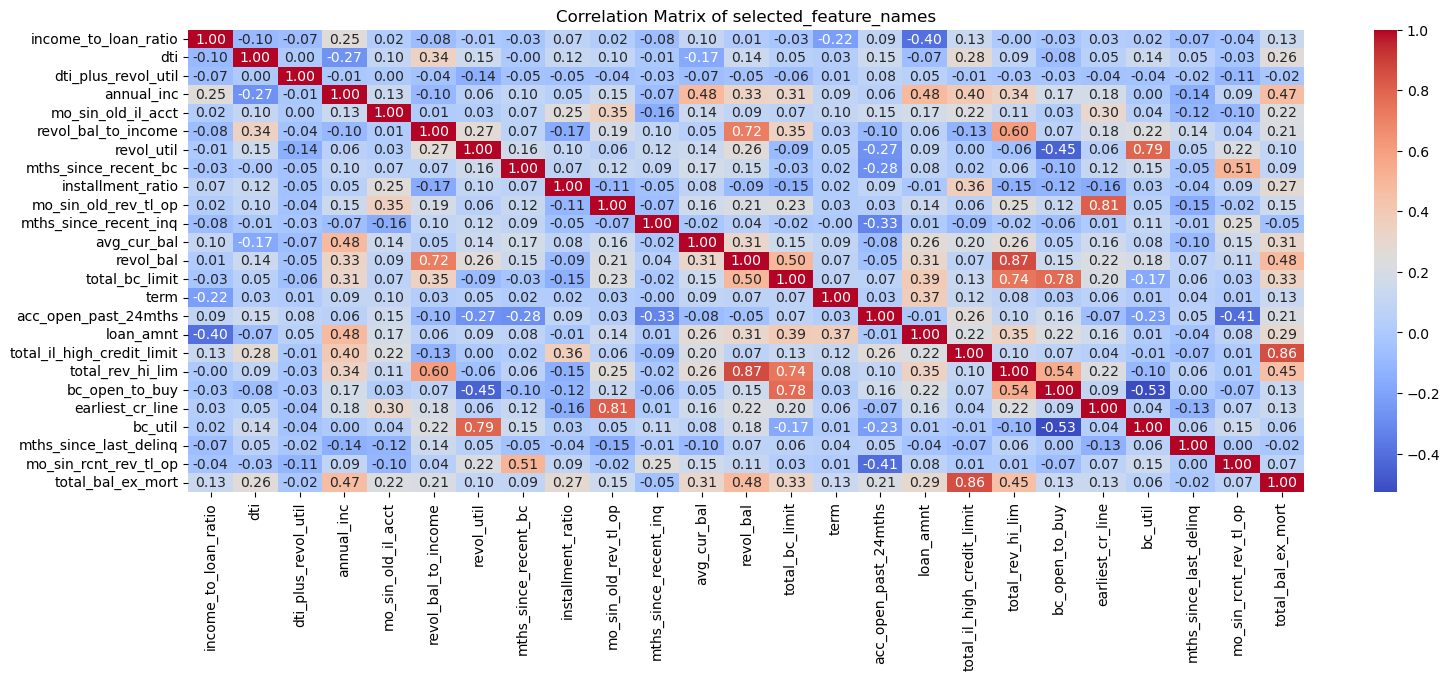

In [58]:
correlation_matrix = X_train[top_n_features].corr()

plt.figure(figsize=(18, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of selected_feature_names')
plt.show()

In [59]:
corr_threshold = 0.7

# Get absolute correlation values and mask diagonal
corr_matrix_abs = X_train[top_n_features].corr().abs()
np.fill_diagonal(corr_matrix_abs.values, 0)

# Find column pairs exceeding the threshold
high_corr_pairs = (corr_matrix_abs > corr_threshold).stack()

# Filter only True values
high_corr_pairs = high_corr_pairs[high_corr_pairs].index.tolist()

for i in high_corr_pairs:
    print(i)


('revol_bal_to_income', 'revol_bal')
('revol_util', 'bc_util')
('mo_sin_old_rev_tl_op', 'earliest_cr_line')
('revol_bal', 'revol_bal_to_income')
('revol_bal', 'total_rev_hi_lim')
('total_bc_limit', 'total_rev_hi_lim')
('total_bc_limit', 'bc_open_to_buy')
('total_il_high_credit_limit', 'total_bal_ex_mort')
('total_rev_hi_lim', 'revol_bal')
('total_rev_hi_lim', 'total_bc_limit')
('bc_open_to_buy', 'total_bc_limit')
('earliest_cr_line', 'mo_sin_old_rev_tl_op')
('bc_util', 'revol_util')
('total_bal_ex_mort', 'total_il_high_credit_limit')


I use my previously calculated feature importance to decide which cols to drop. There is some stochasticity in my notebook that I ran out of time to remove. At this stage, you may need to select uncomment some high correlation features (`earliest_cr_line` and/or `total_bal_ex_mort`) 

In [60]:
drop_for_corr = [
    # "earliest_cr_line", 
    "revol_bal",
    # "total_bal_ex_mort",
    "total_rev_hi_lim",
    "bc_open_to_buy",
    "bc_util",
]

In [61]:
corr_matrix_abs = X_train[top_n_features].drop(columns=drop_for_corr, axis=1).corr().abs()
np.fill_diagonal(corr_matrix_abs.values, 0)
high_corr_pairs = (corr_matrix_abs > corr_threshold).stack()
high_corr_pairs = high_corr_pairs[high_corr_pairs].index.tolist()

print(high_corr_pairs)

[('mo_sin_old_rev_tl_op', 'earliest_cr_line'), ('total_il_high_credit_limit', 'total_bal_ex_mort'), ('earliest_cr_line', 'mo_sin_old_rev_tl_op'), ('total_bal_ex_mort', 'total_il_high_credit_limit')]


In [62]:
top_n_features_no_corr = list(set(top_n_features)-set(drop_for_corr))

## Hyperparameter tuning the best model

In [63]:
model = CatBoostClassifier(silent=True, random_state=42)

param_dist = {
    'iterations': np.random.randint(80, 800, size=3),
    'learning_rate': np.random.uniform(0.01, 0.15, size=3), 
    'depth': np.random.randint(2, 8, size=3),
    'l2_leaf_reg': np.random.uniform(1, 10, size=3),
    'border_count': np.random.randint(70, 129, size=3),
}


random_search = RandomizedSearchCV(estimator=model, param_distributions=param_dist, 
                                   n_iter=50, cv=3, scoring=recall_default_scorer, 
                                   n_jobs=-1, verbose=1, random_state=42)

random_search.fit(X_train[top_n_features_no_corr], y_train)

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best Parameters: {'learning_rate': 0.07112178053264816, 'l2_leaf_reg': 6.720993879569281, 'iterations': 513, 'depth': 4, 'border_count': 71}
Best Score: 0.5964741757194587


I print out the top performers in my random search so that I can tune the parameter grid based on the general pattern of the top performers

In [64]:
pd.DataFrame(random_search.cv_results_)[["mean_test_score","param_learning_rate","param_l2_leaf_reg","param_iterations","param_depth","param_border_count"]].sort_values("mean_test_score", ascending=False).head(8)

mean_test_score  param_learning_rate  param_l2_leaf_reg  param_iterations  \
42         0.596474             0.071122           6.720994               513   
21         0.591467             0.071122           9.967513               235   
23         0.591433             0.106182           6.720994               513   
11         0.591424             0.056831           9.967513               235   
16         0.588922             0.056831           9.967513               235   
0          0.587645             0.106182           6.821839               235   
47         0.586402             0.056831           9.967513               609   
44         0.586397             0.106182           6.821839               513   

    param_depth  param_border_count  
42            4                  71  
21            5                 110  
23            4                 110  
11            4                  90  
16            6                  90  
0             5                 110  
47            4                 110  
44            4                  90

# Evalutation

## Test set model

In [65]:
cb_model = random_search.best_estimator_

In [66]:
predictions = random_search.best_estimator_.predict(X_test[top_n_features_no_corr])

In [67]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

print(recall_score(y_test, predictions, pos_label=0))
print(precision_score(y_test, predictions, pos_label=0))
print(f1_score(y_test, predictions, pos_label=0))
print(roc_auc_score(y_test, predictions))


0.5362318840579711
0.034993694829760405
0.0656999112163362
0.5766358969895761


## Probability thresholding

Usually, models use a probability threshold of 0.5. meaning they a probability of one class above 0.5 means the model will predict that class. However, with a more specific goal in mind, you can tune the probability threshold to whatever is best for your use case.

For our case, if we assume that we want to always detect all defaulters, recall is the parameter to optimise with thresholding. Doing this gets us a recall score of 1 meaning all defaulters are detected, but this comes at the cost of other metrics.

In [68]:
from sklearn.metrics import confusion_matrix

# get predicted probabilities for class 1 (repayers)
prob_predictions = cb_model.predict_proba(X_test[top_n_features_no_corr])
positive_class_probs = prob_predictions[:, 1]  # probability of class 1 (repayers)

threshold = 0.8
threshold_predictions = (positive_class_probs >= threshold).astype(int)

cm = confusion_matrix(y_test, threshold_predictions, labels=[0, 1])

# extract values (for class 0 as "positive")
TP = cm[0, 0]  # True defaulters (correctly caught)
FP = cm[1, 0]  # Repayers wrongly flagged as defaulters (false alarms)
TN = cm[1, 1]  # Repayers correctly identified
FN = cm[0, 1]  # Defaulters missed

# calculate repayers per defaulter ratio
if TP == 0:
    repayers_per_defaulter = float("inf")  # no defaulters are caught
else:
    repayers_per_defaulter = TN / TP  # repayers per caught defaulter

print("="*50)
print(f"Repayers identified per defaulter identified: {repayers_per_defaulter:.2f}")
print("="*50)
print(f"Recall (Defaulters Caught): {recall_score(y_test, threshold_predictions, pos_label=0):.2f}")
print(f"Precision (Defaulters Correct): {precision_score(y_test, threshold_predictions, pos_label=0):.2f}")
print(f"F1 Score: {f1_score(y_test, threshold_predictions, pos_label=0):.2f}")
print(f"ROC AUC: {roc_auc_score(y_test, threshold_predictions):.2f}")
print("="*50)
print("Confusion Matrix:")
print(cm)

Repayers identified per defaulter identified: 5.44
Recall (Defaulters Caught): 0.96
Precision (Defaulters Correct): 0.03
F1 Score: 0.05
ROC AUC: 0.55
Confusion Matrix:
[[ 199    8]
 [6911 1082]]


# Feature analysis

## Feature Importance
Feature importance information is critical to my task. We want the feature importance data to reflect real life, so for my feature importance analysis I will use the test set.

### Perumutation metrics

Permutation feature importance will shuffle the values of features, and see how the performance of a model is impacted. Negative scores indicate features that may need to be removed.

In [69]:
result = permutation_importance(cb_model, X_test[top_n_features_no_corr], y_test, scoring="recall", random_state=42)

importance_df = pd.DataFrame({
    'Feature': X_train[top_n_features_no_corr].columns,
    'Importance': result.importances_mean
})

importance_df = importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

importance_df

Feature  Importance
0         income_to_loan_ratio    0.013136
1          revol_bal_to_income    0.010284
2                  avg_cur_bal    0.010259
3               total_bc_limit    0.009058
4             earliest_cr_line    0.008057
5                   revol_util    0.006656
6         mo_sin_old_rev_tl_op    0.006055
7       mths_since_last_delinq    0.004454
8            installment_ratio    0.001376
9   total_il_high_credit_limit    0.000525
10       mo_sin_rcnt_rev_tl_op   -0.000400
11                        term   -0.000751
12        mths_since_recent_bc   -0.002702
13        acc_open_past_24mths   -0.002702
14         dti_plus_revol_util   -0.003103
15          mo_sin_old_il_acct   -0.004679
16                  annual_inc   -0.005680
17                   loan_amnt   -0.006280
18       mths_since_recent_inq   -0.006431
19                         dti   -0.011185
20           total_bal_ex_mort   -0.020993

### SHAP

In [70]:
# get SHAP values
explainer = shap.Explainer(random_search.best_estimator_, X_test[top_n_features_no_corr])

The SHAP summary plot tells us the most important features in the model.

 99%|===================| 8098/8200 [01:16<00:00]        /home/javonne/anaconda3/envs/fraud/lib/python3.12/site-packages/shap/plots/_beeswarm.py:873: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pl.barh(y_pos, global_shap_values[feature_inds], 0.7, align='center', color=color)


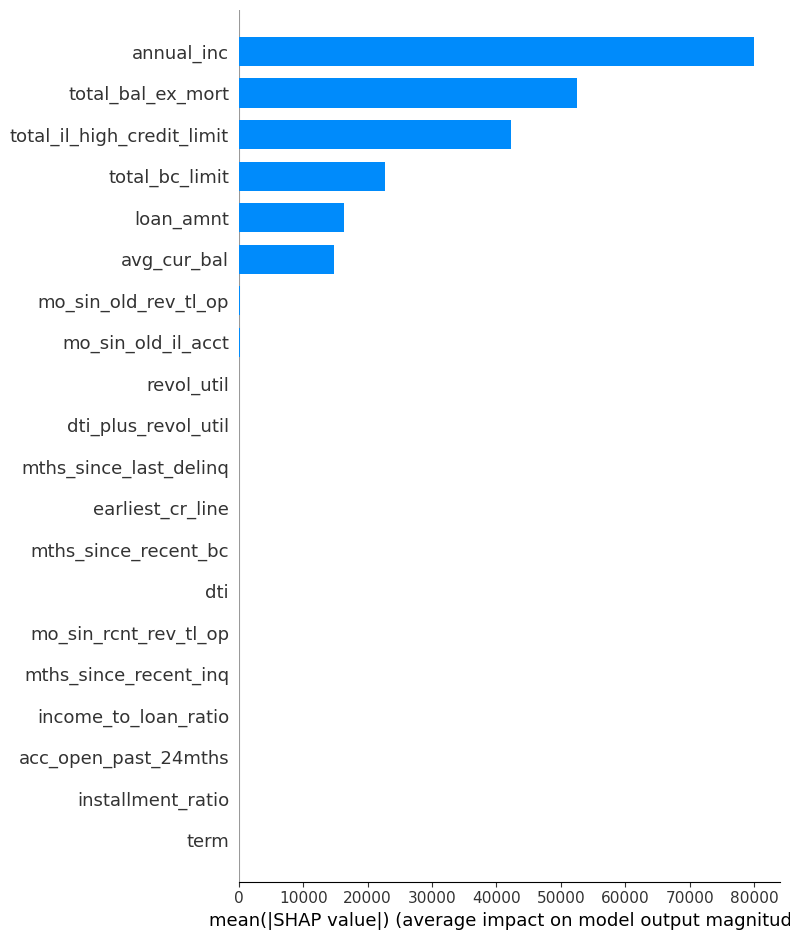

In [71]:
shap_values = explainer(X_test[top_n_features_no_corr])
shap.summary_plot(X_test[top_n_features_no_corr], feature_names=top_n_features_no_corr, plot_type="bar")

Here you can see the waterfall plot for one specific prediction. We get a really clear idea of how the model reaches the final prediction for a given datapoint.

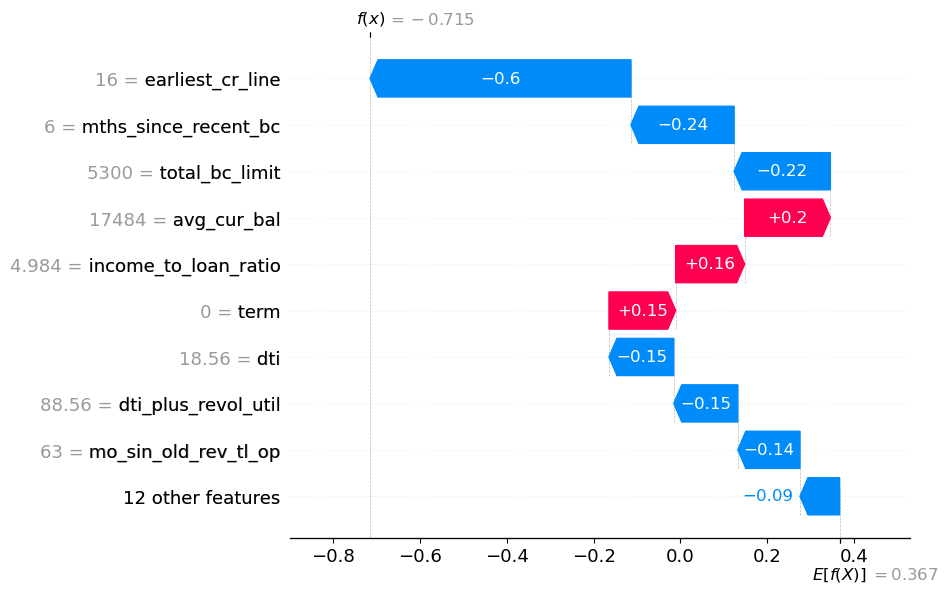

In [72]:
shap.waterfall_plot(shap_values[66])

# Notes, Possible Improvements, and Weaknesses

Notes
-  There are many decision points in this task that allow me to make competing assumptions. Broadly, I prioritise minimising the chance of a defaulter going undetected (Hence my choice of recall as a metric). However, I do acknowledge that this comes at the cost of revenue to the loaner.
-  This type of model is not used to make predictions, only to inform the investigation of prospective loan recipients. Some of the metrics are suboptimal, but this is to be expected when working with such an imbalanced dataset.
-  I had some level of uncertainty about `SequentialFeatureSelection` I considered not using it in favour of built-in regularisation, but decided to go with it because regularisation and SequentialFeatureSelection take place at different layers in the design process. While regularisation is good, SequentialFeatureSelection can give what are objectively the best features. Unfortunately, my machine had several resource-related errors (RAM) so I did end up having to skip it.
-  I implemented ElasticNet for regularisation but decided to remove it. I knew from the start that I was going to be using tree-based models which do not benefit from feature scaling. I still used scaling for compatibility with ElasticNet, but I decided to use built-in alternatives. I choose built-in regularisation because:
    1. It's a much more computationally efficient solution
    2. It's a much easier process to follow
    3. I generally prefer to go with built-in solutions where possible. For example in this case, while ElasticNet CAN be used for regularisation in classification tasks, that is not what it is designed for. I believe it is safer to use a built-in solution in cases like this.
-  I would have liked to spend more time iterating over my solution. For example, with feature engineering, I would have liked to go back and change/engineer new features after my initial regularisation-based feature importance.


Future Work
- One way to improve my solution is with a cleaner usage of SKlearn pipelines. I was forced to think very hard about my use of pipelines and column transformers in this project, and I think if I had more time, I could do better. For example, feature engineering. It is unclear to me whether or not it is best to do that in the pipeline, or outside of it, but I ultimately decided to keep it inside the pipeline because of the rule "Anything that is done to both the training input data and the test input data equally should be done in a pipeline". I think I can do a better job with pipelines/column transformers in the future.
- I could optimise my usage of the `fit` function in the creation of custom Sklearn transformers, which would make my code more modular and more appropriate for production environments. The ideal usage of pipelines is visible in the `NanColumnRemover`, where I dynamically detect relevant features and then transform them separately.
- I think I can improve how I handle the features more efficiently. I like my lists, but I could use a more robust methodology to keep everything in order and make it more understandable (Especially important in production environments, where others may need to look at your code). I think the main improvements would be:
  1. A flow chart for the features (For understandability)
  2. More asserts to perform sanity checks e.g. me checking that all of my nan lists have the same total len as the number of columns (For validation)
- I would have liked to investigate feature reintroduction if I had more time.
- I would have like to do feature reintroduction analysis if i had more time.
